Saving SARexample.png to SARexample (2).png
Otsu threshold: 113.60546875


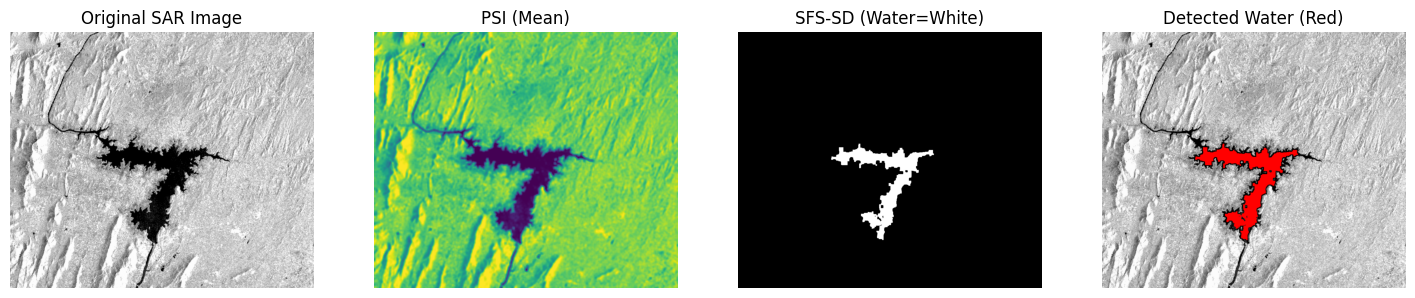

In [ ]:
import cv2 # ---------------------------------SAR IMAGES BASED ON EQUATION GRAPHS W/ OTSU METHOD (WORKED GOOD FOR DARKER SAR IMAGES, BUT DIDNT DETECT ENTIRETY OF WATER BODY FOR LIGHT SAR IMAGES CONNECTING STREAMS AND SMALL PONDS WERE NOT IDENTIFIFIED)
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.filters import threshold_otsu
from scipy.ndimage import uniform_filter, label, binary_opening

# STEP 1: UPLOAD & LOAD IMAGE
# Let’s upload a SAR image. SAR images are grayscale so we read it as grayscale.
# Converting to float32 makes calculations easier later.
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # grab the uploaded file name
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape  # save height and width for later use
# Using float32 allows for more precise calculations when computing local means, standard deviations, and thresholds.

# STEP 2: COMPUTE SFS-SD (LOCAL STANDARD DEVIATION) UNIFORMITY
# This measures how “uniform” each small patch is. Water is very uniform, land not so much.
# Using a 8x8 window gives a good balance between detail and noise smoothing.
window_size = 8
mean_local = uniform_filter(img, size=window_size)       # average of each 8x8 patch
sq_mean_local = uniform_filter(img**2, size=window_size) # average of squared values
SFS_SD = np.sqrt(sq_mean_local - mean_local**2)          # std dev formula: sqrt(E[x^2] - (E[x])^2)

# STEP 3: OTSU THRESHOLD FOR INTENSITY
# Automatically finds a cutoff separating dark (water) and bright (land) pixels.
# This avoids manually picking a threshold and works well for most SAR images.
otsu_thresh = threshold_otsu(img)
print(f"Otsu threshold: {otsu_thresh}")  # just to see the threshold value

# STEP 4: CREATE WATER CANDIDATE MASK
# First, mark all dark pixels below Otsu threshold
dark_mask = img < otsu_thresh
# Then, mark only the homogeneous areas (low SFS-SD)
homogeneous_mask = SFS_SD < np.percentile(SFS_SD, 25)
# Combine them: only dark AND homogeneous areas are water candidates
water_candidate_mask = dark_mask & homogeneous_mask

# STEP 5: KEEP ONLY BIG REGIONS
# Small patches could be shadows or noise, we don’t want those
min_region_fraction = 0.01  # regions must be at least 1% of total image
min_region_size = int(min_region_fraction * h * w)
labeled, num_features = label(water_candidate_mask)
water_mask = np.zeros_like(water_candidate_mask, dtype=bool)
# Keep only regions big enough
for region_label in range(1, num_features + 1):
    region = (labeled == region_label)
    if region.sum() >= min_region_size:
        water_mask |= region

# STEP 6: CLEAN SMALL SPECKLES
# Even after filtering, tiny isolated pixels can remain.
# Binary opening removes these while keeping rivers/lakes intact.
water_mask = binary_opening(water_mask, structure=np.ones((5,5)))

# STEP 7: CREATE SFS-SD IMAGE FOR VISUALIZATION
# For visualization, make a binary image: water=white, land=black
SFS_SD_vis = water_mask.astype(float)

# STEP 8: DETECTED WATER OVERLAY
# Convert grayscale image to RGB so we can overlay water in red
img_rgb = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
img_rgb[water_mask] = [255, 0, 0]  # color water pixels red

# STEP 9: PSI IMAGE (MEAN LOCAL INTENSITY)
# PSI is just the local mean we already computed. Shows average intensity per patch.
PSI = mean_local

# STEP 10: VISUALIZATION COLLAGE
# Show original, PSI, SFS-SD, and red water overlay side by side
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
plt.title("Original SAR Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title("PSI (Mean)")
plt.imshow(PSI, cmap='viridis')
plt.axis('off')

plt.subplot(1,4,3)
plt.title("SFS-SD (Water=White)")
plt.imshow(SFS_SD_vis, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title("Detected Water (Red)")
plt.imshow(img_rgb)
plt.axis('off')

plt.show()


Saving E48DE867-F358-49F8-9B31-7A45EB89454D.jpeg to E48DE867-F358-49F8-9B31-7A45EB89454D (1).jpeg


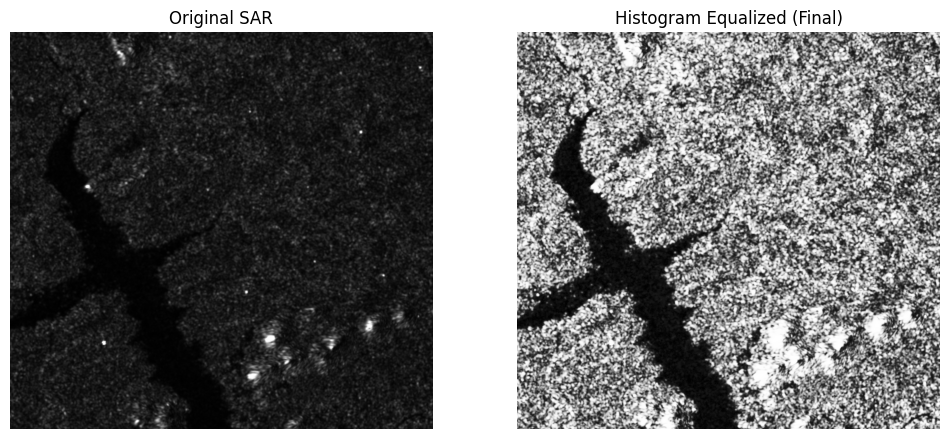

In [ ]:
import cv2  # ---------- CONTRAST CONVERSION FOR DARKER IMAGES TO ADD UNIFROMITY AMONG IMAGES SINCE RESULTS WITH IDENTIFICATION CODE WAS VARYING ----------
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# STEP 1: UPLOAD IMAGE
# Upload your SAR image. SAR images are grayscale, so we read them in single-channel mode.
# Grayscale is enough because we only care about intensity differences.
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # grab the uploaded file name
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# STEP 2: HISTOGRAM EQUALIZATION
# This spreads out pixel intensities to improve contrast.
# Dark areas (like water) become darker, land becomes lighter.
# Helps distinguish water vs land even if some land patches are slightly dark.
eq_img = cv2.equalizeHist(img)

# STEP 3: VISUALIZATION COMPARISON
# We'll show the original and enhanced images side by side to check how well the contrast worked.
plt.figure(figsize=(12,6))

# 1 row, 2 columns, 1st subplot (left side)
plt.subplot(1,2,1)
# Explanation of numbers:
# 1 - number of rows in the grid
# 2 - number of columns in the grid
# 1 - index of this subplot (first box, counting left to right)
plt.title("Original SAR")
plt.imshow(img, cmap='gray')  # show original image
plt.axis('off')

# 1 row, 2 columns, 2nd subplot (right side)
plt.subplot(1,2,2)
# Same grid, index=2 - second box (right side)
plt.title("Histogram Equalized (Final)")
plt.imshow(eq_img, cmap='gray')  # show enhanced image
plt.axis('off')

plt.show()


Saving SARexample.png to SARexample (1).png
Otsu threshold: 113.056640625


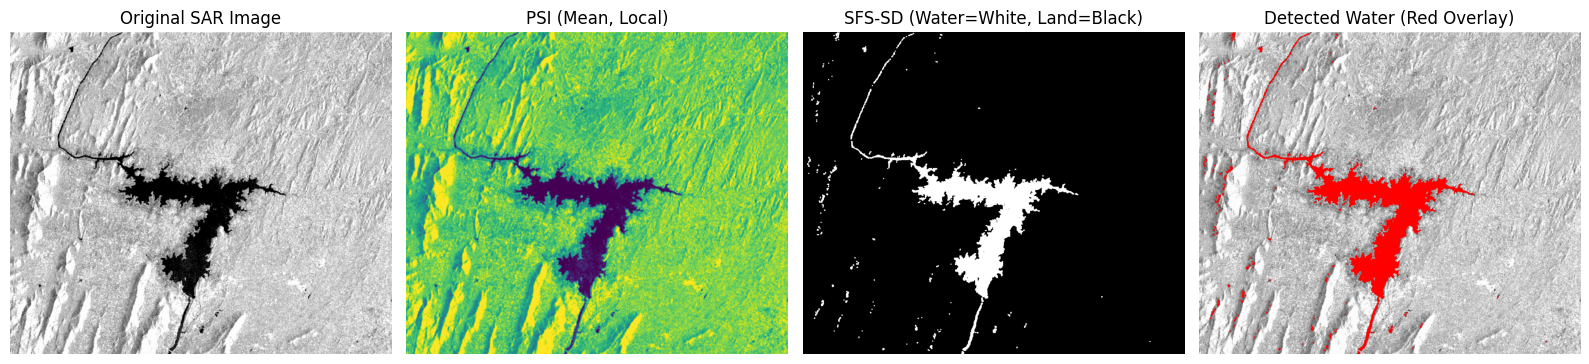

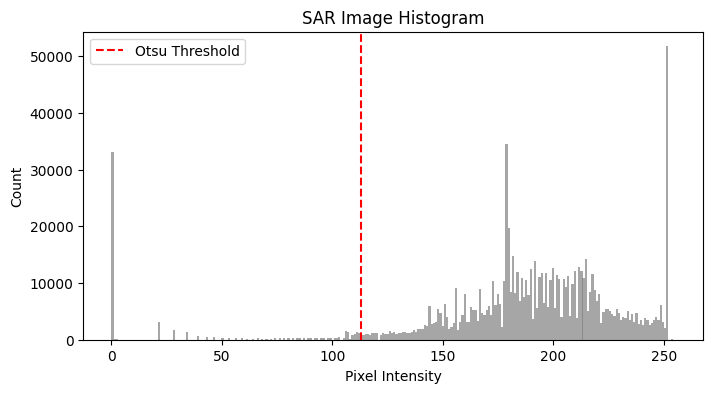

In [ ]:
#--------------------------- BETTER IDENTIFICATION RESULTS, SAR IMAGES BASED ON EQUATION GRAPHS W/ OTSU METHOD (WORKS WELL FOR BOTH ENHANCED DARK AND LIGHT IMAGES)
import cv2  # for reading images and converting them, handles grayscale easily
import numpy as np  # for arrays and numeric operations
import matplotlib.pyplot as plt  # for plotting images and graphs
from google.colab import files  # to upload images in colab
from scipy.ndimage import uniform_filter, binary_opening  # uniform_filter for mean/SD, binary_opening to clean small spots

# STEP 1: UPLOAD & LOAD IMAGE
uploaded = files.upload()  # prompt to pick a file
filename = list(uploaded.keys())[0]  # grab the uploaded file name
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)  # read grayscale, convert to float32 for accurate calculations
h, w = img.shape  # save height and width

# STEP 2: COMPUTE HISTOGRAM FOR OTSU
num_bins = 256  # 8-bit image, intensity levels 0-255
hist_counts, bin_edges = np.histogram(img, bins=num_bins, range=(0, 255))  # counts of each intensity
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # midpoints for plotting

# STEP 3: COMPUTE BETWEEN-CLASS SUM OF SQUARES (BSS) FOR OTSU THRESHOLD
total = hist_counts.sum()  # total pixels
sum_total = (bin_centers * hist_counts).sum()  # total intensity sum
bss_list = []  # store BSS for each threshold

for i in range(1, num_bins):
    w0 = hist_counts[:i].sum() / total  # fraction of pixels below threshold
    w1 = hist_counts[i:].sum() / total  # fraction above threshold
    if w0 == 0 or w1 == 0:  # avoid division by zero
        bss_list.append(0)
        continue
    mu0 = (bin_centers[:i] * hist_counts[:i]).sum() / hist_counts[:i].sum()  # mean below threshold
    mu1 = (bin_centers[i:] * hist_counts[i:]).sum() / hist_counts[i:].sum()  # mean above threshold
    bss = w0 * (mu0 - sum_total / total) ** 2 + w1 * (mu1 - sum_total / total) ** 2  # between-class variance
    bss_list.append(bss)

bss_array = np.array(bss_list)
otsu_index = bss_array.argmax()  # find threshold with max BSS
otsu_thresh = bin_centers[otsu_index]  # actual intensity value
print(f"Otsu threshold: {otsu_thresh}")  # check threshold

# STEP 4: CREATE INITIAL WATER MASK
water_mask = img < otsu_thresh  # pixels darker than threshold = water candidates

# STEP 5: CLEAN SMALL SPECKLES
water_mask = binary_opening(water_mask, structure=np.ones((3,3)))  # remove tiny isolated pixels

# STEP 6: DETECTED WATER OVERLAY
img_rgb = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)  # convert to RGB
img_rgb[water_mask] = [255, 0, 0]  # overlay red for water pixels

# STEP 7: COMPUTE PSI (MEAN LOCAL INTENSITY)
kernel_size = 3  # small 3x3 neighborhood
pad = kernel_size // 2
PSI = np.zeros_like(img)
padded = np.pad(img, pad, mode='reflect')  # handle borders
for i in range(h):
    for j in range(w):
        neighborhood = padded[i:i+kernel_size, j:j+kernel_size]  # local patch
        PSI[i,j] = neighborhood.mean()  # local mean

# STEP 8: COMPUTE SFS-SD (STANDARD DEVIATION IMAGE)
window_size = 9  # 9x9 neighborhood for SD
mean_local = uniform_filter(img, size=window_size)  # mean in 9x9
sq_mean_local = uniform_filter(img**2, size=window_size)  # mean of squares
SFS_SD = np.sqrt(sq_mean_local - mean_local**2)  # SD formula

# STEP 9: CREATE BINARY SFS-SD VISUALIZATION
SFS_SD_vis = np.zeros_like(img, dtype=np.uint8)  # start black
SFS_SD_vis[water_mask] = 255  # water = white, land = black

# STEP 10: VISUALIZATION COLLAGE
plt.figure(figsize=(16,6))

plt.subplot(1,4,1)  # 1 row, 4 columns, first slot
plt.title("Original SAR Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)  # second slot
plt.title("PSI (Mean, Local)")
plt.imshow(PSI, cmap='viridis')
plt.axis('off')

plt.subplot(1,4,3)  # third slot
plt.title("SFS-SD (Water=White, Land=Black)")
plt.imshow(SFS_SD_vis, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)  # fourth slot
plt.title("Detected Water (Red Overlay)")
plt.imshow(img_rgb)
plt.axis('off')

plt.tight_layout()  # avoid overlap
plt.show()

# STEP 11: PLOT HISTOGRAM WITH OTSU THRESHOLD
plt.figure(figsize=(8,4))
plt.bar(bin_centers, hist_counts, width=1, color='gray', alpha=0.7)
plt.axvline(otsu_thresh, color='red', linestyle='--', label='Otsu Threshold')
plt.title("SAR Image Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.legend()
plt.show()


Saving Screenshot 2025-09-11 101944.png to Screenshot 2025-09-11 101944 (1).png


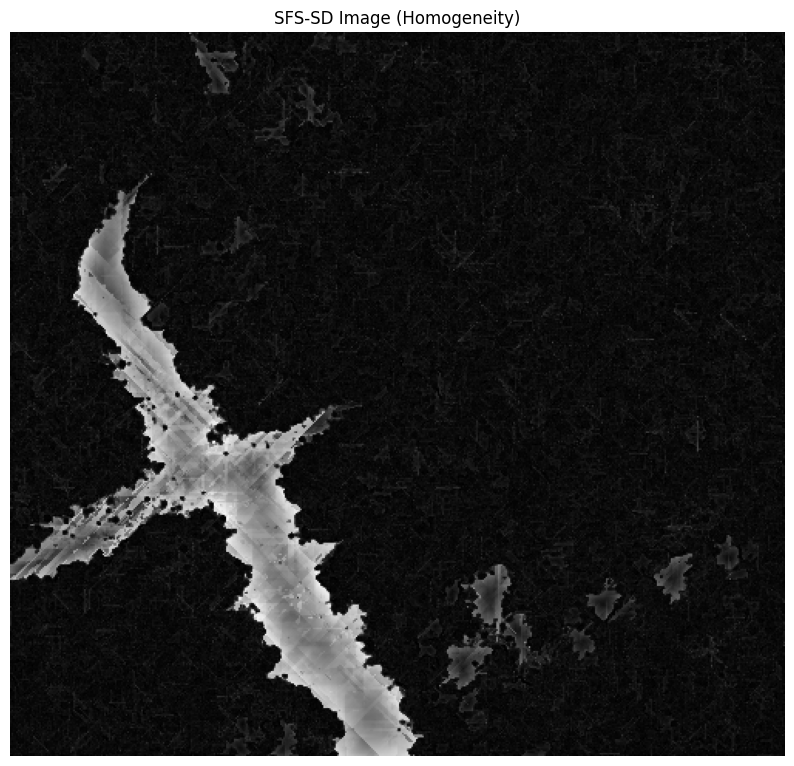

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import binary_opening

# ----------------- STEP 1: UPLOAD & LOAD IMAGE -----------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

# ----------------- STEP 2: DEFINE DIRECTIONS -----------------
# 8 directions: N, NE, E, SE, S, SW, W, NW
directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]
T1 = 20  # maximum difference allowed along direction
T2 = 40   # maximum line length

# ----------------- STEP 3: COMPUTE SFS-SD -----------------
SFS_SD = np.zeros_like(img, dtype=np.float32)
PSI = np.zeros_like(img, dtype=np.float32)

for i in range(h):
    for j in range(w):
        di_list = []
        for dy, dx in directions:
            y, x = i, j
            length = 0
            while True:
                y_new, x_new = y + dy, x + dx
                if y_new < 0 or y_new >= h or x_new < 0 or x_new >= w:
                    break
                PH = abs(img[y_new, x_new] - img[i, j])
                if PH > T1 or length >= T2:
                    break
                y, x = y_new, x_new
                length += 1
            # compute distance from central pixel to end pixel
            di = np.sqrt((y - i)**2 + (x - j)**2)
            di_list.append(di)
        if len(di_list) > 0:
            PSI[i,j] = np.mean(di_list)
            SFS_SD[i,j] = np.sqrt(np.sum((np.array(di_list) - PSI[i,j])**2) / (len(di_list)-1 + 1e-6))

# ----------------- STEP 4: VISUALIZE SFS-SD -----------------
# Normalize for display
SFS_SD_vis = (SFS_SD - np.min(SFS_SD)) / (np.max(SFS_SD) - np.min(SFS_SD)) * 255
SFS_SD_vis = SFS_SD_vis.astype(np.uint8)

plt.figure(figsize=(10,10))
plt.title("SFS-SD Image (Homogeneity)")
plt.imshow(SFS_SD_vis, cmap='gray')
plt.axis('off')
plt.show()


Saving Screenshot 2025-09-11 101944.png to Screenshot 2025-09-11 101944 (2).png
Loaded SFS-SD image shape: (469, 502)
Prototypes coords: (np.int64(0), np.int64(0)) (np.int64(265), np.int64(132))


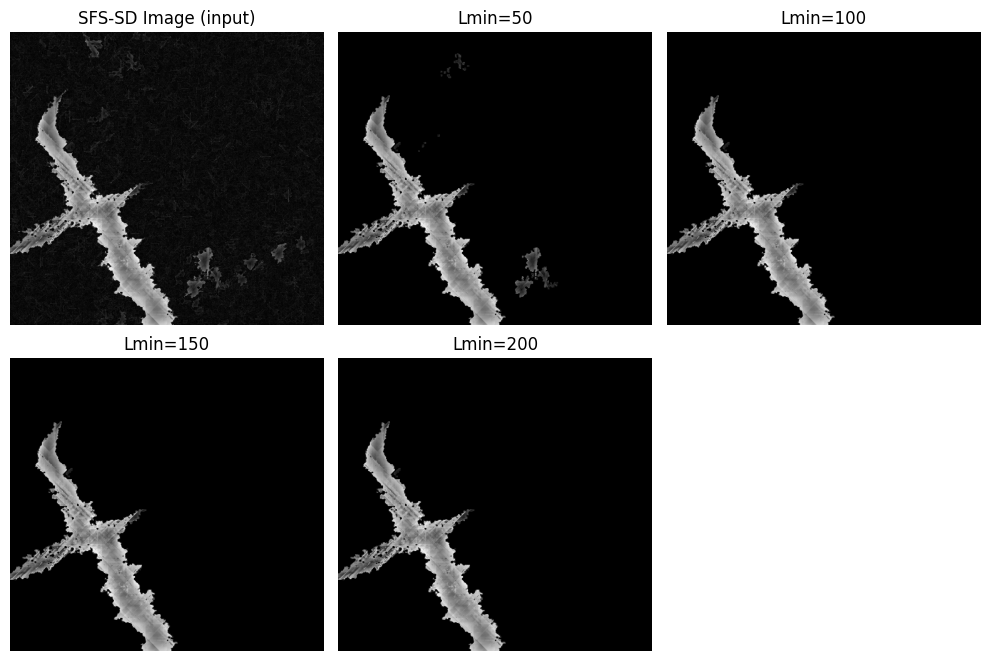

In [ ]:
import numpy as np, cv2, os
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_opening
from collections import deque

uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

h,w = SFS_SD_vis.shape
print("Loaded SFS-SD image shape:", SFS_SD_vis.shape)

# BFS diameter helper (two-pass)
def component_diameter(coords_set):
    if not coords_set:
        return 0
    start = next(iter(coords_set))
    def bfs(start):
        q = deque([start])
        visited = {start: 0}
        while q:
            r, c = q.popleft()
            d = visited[(r,c)]
            for dr in (-1,0,1):
                for dc in (-1,0,1):
                    if dr == 0 and dc == 0:
                        continue
                    nr, nc = r+dr, c+dc
                    if (nr,nc) in coords_set and (nr,nc) not in visited:
                        visited[(nr,nc)] = d+1
                        q.append((nr,nc))
        far_node = max(visited.items(), key=lambda x: x[1])[0]
        far_dist = visited[far_node]
        return far_node, far_dist
    A, _ = bfs(start)
    _, diameter = bfs(A)
    return diameter

# path-opening mask function (keeps radiometry values when mask passes)
def path_opening_mask(sfs_img, percentile=78, Lmin=100):
    th_val = np.percentile(sfs_img, percentile)
    binary_candidate = (sfs_img >= th_val).astype(np.uint8)
    structure = np.ones((3,3), dtype=int)
    labeled, num_labels = label(binary_candidate, structure=structure)
    final_mask = np.zeros_like(binary_candidate, dtype=np.uint8)
    for lab in range(1, num_labels+1):
        comp_coords = np.argwhere(labeled == lab)
        coords_set = set((int(r),int(c)) for r,c in comp_coords)
        if len(coords_set) < Lmin:
            continue
        dia = component_diameter(coords_set)
        if dia >= Lmin:
            for (r,c) in coords_set:
                final_mask[r,c] = 1
    final_mask_clean = binary_opening(final_mask, structure=np.ones((3,3))).astype(np.uint8)
    return final_mask_clean

# PARAMETERS
Lmin_values = [50, 100, 150, 200]
percentile = 78
gamma = 0.6  # ignorance scaling

# Build stack: each element is radiometry (original SFS_SD_vis) masked by path-opening mask
stack = []
masks = []
for L in Lmin_values:
    mask = path_opening_mask(SFS_SD_vis, percentile=percentile, Lmin=L)
    masks.append(mask)
    img_masked = (SFS_SD_vis * mask).astype(np.uint8)
    stack.append(img_masked)

stack_arr = np.stack(stack, axis=-1).astype(np.float32)  # shape (h,w,N)
N = stack_arr.shape[-1]
sums = stack_arr.sum(axis=-1)  # sum across stack for each pixel

# prototypes: L_min (global min sum) and L_max (global max sum)
min_idx = np.unravel_index(np.argmin(sums), sums.shape)
max_idx = np.unravel_index(np.argmax(sums), sums.shape)
L_min_proto = stack_arr[min_idx]  # vector length N
L_max_proto = stack_arr[max_idx]
L_mid_proto = (L_min_proto + L_max_proto) / 2.0

print("Prototypes coords:", min_idx, max_idx)

# Flatten for per-pixel computation
flat_stack = stack_arr.reshape(-1, N)  # (h*w, N)
protos = np.vstack([L_min_proto, L_mid_proto, L_max_proto]).astype(np.float32)  # (3,N)

# distances and similarities
# --- Evidential mass computation (Eq. 11–13) ---
alpha = 1.0
dists = np.linalg.norm(flat_stack[:, None, :] - protos[None, :, :], axis=-1)  # (M,3)
phi = np.exp(-gamma * dists**2)  # Eq. 12

# Initial masses per prototype source
mass_sources = []
for k in range(protos.shape[0]):
    mk = np.zeros((flat_stack.shape[0], 4))
    mk[:,k] = alpha * phi[:,k]
    mk[:,3] = 1 - alpha * phi[:,k]  # ignorance
    mass_sources.append(mk)

# Dempster’s combination operator (Eq. 13–14)
def dempster_combine(m1, m2):
    """
    Combine two mass functions m1, m2 using Dempster's rule of combination.
    Each m: [N,4] = [C1, C2, C3, Ω]
    """
    combined = np.zeros_like(m1)

    # Conflict mass (denominator term in Eq.14)
    conflict = (
        m1[:,0]*(m2[:,1]+m2[:,2]) +
        m1[:,1]*(m2[:,0]+m2[:,2]) +
        m1[:,2]*(m2[:,0]+m2[:,1])
    )
    denom = 1 - conflict + 1e-8

    # Combine masses for each specific class
    for i in range(3):
        combined[:,i] = (
            m1[:,i]*(m2[:,i] + m2[:,3]) + m1[:,3]*m2[:,i]
        ) / denom

    # Combine mass assigned to Ω (ignorance)
    combined[:,3] = (m1[:,3] * m2[:,3]) / denom
    return combined


# Combine all sources using Dempster’s rule
m_total = mass_sources[0]
for k in range(1, len(mass_sources)):
    m_total = dempster_combine(m_total, mass_sources[k])

mass_arr = m_total  # [M,4]

mass_maps = mass_arr.reshape(h, w, 4)
mC1 = mass_maps[:,:,0]; mC2 = mass_maps[:,:,1]; mC3 = mass_maps[:,:,2]; mO = mass_maps[:,:,3]

# Hard segmentation (choose singleton with highest mass; mark unknown where m(Ω) dominates)
singletons = np.stack([mC1, mC2, mC3], axis=-1)
labels = np.argmax(singletons, axis=-1) + 1
unknown_mask = (mO > singletons.max(axis=-1))
labels[unknown_mask] = 0

# Display outputs preserving grayscale mapping (bright stays bright)
plt.figure(figsize=(10,10))
plt.subplot(3,3,1); plt.imshow(SFS_SD_vis, cmap='gray'); plt.title("SFS-SD Image (input)"); plt.axis('off')
for i,L in enumerate(Lmin_values):
    plt.subplot(3,3,2+i); plt.imshow(stack[i], cmap='gray'); plt.title(f"Lmin={L}"); plt.axis('off')
plt.tight_layout()
plt.show()

Saving fd2.png to fd2 (2).png


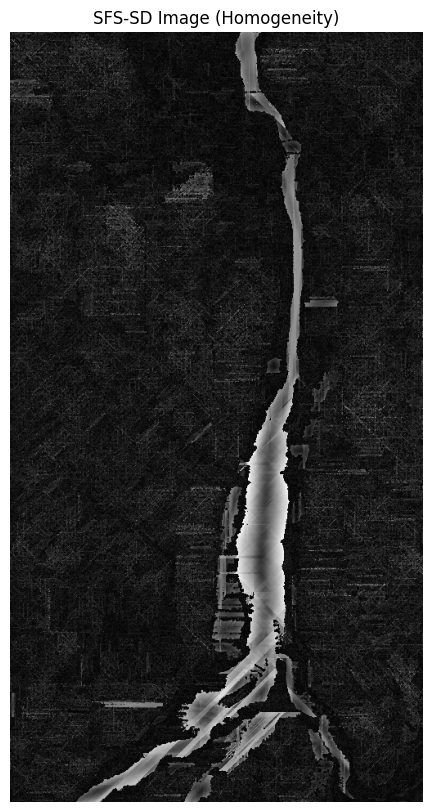

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import binary_opening

# ----------------- STEP 1: UPLOAD & LOAD IMAGE -----------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

# ----------------- STEP 2: DEFINE DIRECTIONS -----------------
# 8 directions: N, NE, E, SE, S, SW, W, NW
directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]
T1 = 20  # maximum difference allowed along direction
T2 = 40   # maximum line length

# ----------------- STEP 3: COMPUTE SFS-SD -----------------
SFS_SD = np.zeros_like(img, dtype=np.float32)
PSI = np.zeros_like(img, dtype=np.float32)

for i in range(h):
    for j in range(w):
        di_list = []
        for dy, dx in directions:
            y, x = i, j
            length = 0
            while True:
                y_new, x_new = y + dy, x + dx
                if y_new < 0 or y_new >= h or x_new < 0 or x_new >= w:
                    break
                PH = abs(img[y_new, x_new] - img[i, j])
                if PH > T1 or length >= T2:
                    break
                y, x = y_new, x_new
                length += 1
            # compute distance from central pixel to end pixel
            di = np.sqrt((y - i)**2 + (x - j)**2)
            di_list.append(di)
        if len(di_list) > 0:
            PSI[i,j] = np.mean(di_list)
            SFS_SD[i,j] = np.sqrt(np.sum((np.array(di_list) - PSI[i,j])**2) / (len(di_list)-1 + 1e-6))

# ----------------- STEP 4: VISUALIZE SFS-SD -----------------
# Normalize for display
SFS_SD_vis = (SFS_SD - np.min(SFS_SD)) / (np.max(SFS_SD) - np.min(SFS_SD)) * 255
SFS_SD_vis = SFS_SD_vis.astype(np.uint8)

plt.figure(figsize=(10,10))
plt.title("SFS-SD Image (Homogeneity)")
plt.imshow(SFS_SD_vis, cmap='gray')
plt.axis('off')
plt.show()

Saving fd2.png to fd2 (2).png
Loaded SFS-SD image shape: (942, 505)
Prototypes coords: (np.int64(0), np.int64(0)) (np.int64(605), np.int64(336))


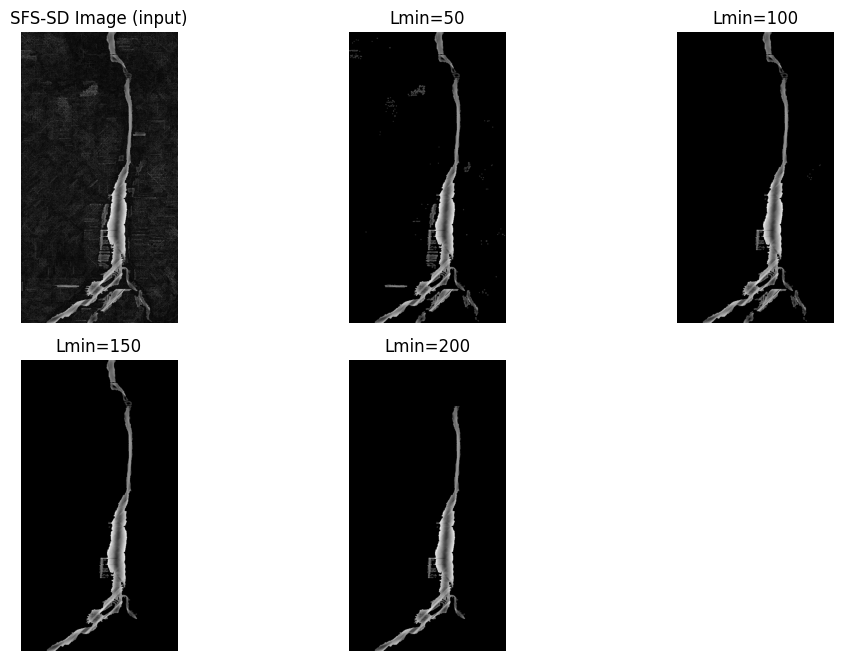

In [ ]:
import numpy as np, cv2, os
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_opening
from collections import deque

uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

h,w = SFS_SD_vis.shape
print("Loaded SFS-SD image shape:", SFS_SD_vis.shape)

# BFS diameter helper (two-pass)
def component_diameter(coords_set):
    if not coords_set:
        return 0
    start = next(iter(coords_set))
    def bfs(start):
        q = deque([start])
        visited = {start: 0}
        while q:
            r, c = q.popleft()
            d = visited[(r,c)]
            for dr in (-1,0,1):
                for dc in (-1,0,1):
                    if dr == 0 and dc == 0:
                        continue
                    nr, nc = r+dr, c+dc
                    if (nr,nc) in coords_set and (nr,nc) not in visited:
                        visited[(nr,nc)] = d+1
                        q.append((nr,nc))
        far_node = max(visited.items(), key=lambda x: x[1])[0]
        far_dist = visited[far_node]
        return far_node, far_dist
    A, _ = bfs(start)
    _, diameter = bfs(A)
    return diameter

# path-opening mask function (keeps radiometry values when mask passes)
def path_opening_mask(sfs_img, percentile=78, Lmin=100):
    th_val = np.percentile(sfs_img, percentile)
    binary_candidate = (sfs_img >= th_val).astype(np.uint8)
    structure = np.ones((3,3), dtype=int)
    labeled, num_labels = label(binary_candidate, structure=structure)
    final_mask = np.zeros_like(binary_candidate, dtype=np.uint8)
    for lab in range(1, num_labels+1):
        comp_coords = np.argwhere(labeled == lab)
        coords_set = set((int(r),int(c)) for r,c in comp_coords)
        if len(coords_set) < Lmin:
            continue
        dia = component_diameter(coords_set)
        if dia >= Lmin:
            for (r,c) in coords_set:
                final_mask[r,c] = 1
    final_mask_clean = binary_opening(final_mask, structure=np.ones((3,3))).astype(np.uint8)
    return final_mask_clean

# PARAMETERS
Lmin_values = [50, 100, 150, 200]
percentile = 78
gamma = 0.6  # ignorance scaling

# Build stack: each element is radiometry (original SFS_SD_vis) masked by path-opening mask
stack = []
masks = []
for L in Lmin_values:
    mask = path_opening_mask(SFS_SD_vis, percentile=percentile, Lmin=L)
    masks.append(mask)
    img_masked = (SFS_SD_vis * mask).astype(np.uint8)
    stack.append(img_masked)

stack_arr = np.stack(stack, axis=-1).astype(np.float32)  # shape (h,w,N)
N = stack_arr.shape[-1]
sums = stack_arr.sum(axis=-1)  # sum across stack for each pixel

# prototypes: L_min (global min sum) and L_max (global max sum)
min_idx = np.unravel_index(np.argmin(sums), sums.shape)
max_idx = np.unravel_index(np.argmax(sums), sums.shape)
L_min_proto = stack_arr[min_idx]  # vector length N
L_max_proto = stack_arr[max_idx]
L_mid_proto = (L_min_proto + L_max_proto) / 2.0

print("Prototypes coords:", min_idx, max_idx)

# Flatten for per-pixel computation
flat_stack = stack_arr.reshape(-1, N)  # (h*w, N)
protos = np.vstack([L_min_proto, L_mid_proto, L_max_proto]).astype(np.float32)  # (3,N)

# distances and similarities
# --- Evidential mass computation (Eq. 11–13) ---
alpha = 1.0
dists = np.linalg.norm(flat_stack[:, None, :] - protos[None, :, :], axis=-1)  # (M,3)
phi = np.exp(-gamma * dists**2)  # Eq. 12

# Initial masses per prototype source
mass_sources = []
for k in range(protos.shape[0]):
    mk = np.zeros((flat_stack.shape[0], 4))
    mk[:,k] = alpha * phi[:,k]  #
    mk[:,3] = 1 - alpha * phi[:,k]  # ignorance
    mass_sources.append(mk)

#--------------------------------------------------
# Dempster’s combination operator (Eq. 13–14)
def dempster_combine(m1, m2):
    """
    Combine two mass functions m1, m2 using Dempster's rule of combination.
    Each m: [N,4] = [C1, C2, C3, Ω]
    """
    combined = np.zeros_like(m1)

    # Conflict mass (denominator term in Eq.14)
    conflict = (
        m1[:,0]*(m2[:,1]+m2[:,2]) +
        m1[:,1]*(m2[:,0]+m2[:,2]) +
        m1[:,2]*(m2[:,0]+m2[:,1])
    )
    denom = 1 - conflict + 1e-8

    # Combine masses for each specific class
    for i in range(3):
        combined[:,i] = (
            m1[:,i]*(m2[:,i] + m2[:,3]) + m1[:,3]*m2[:,i]
        ) / denom

    # Combine mass assigned to Ω (ignorance)
    combined[:,3] = (m1[:,3] * m2[:,3]) / denom
    return combined


#--------------------------------------------------

# Combine all sources using Dempster’s rule
m_total = mass_sources[0]
for k in range(1, len(mass_sources)):
    m_total = dempster_combine(m_total, mass_sources[k])

mass_arr = m_total  # [M,4]

mass_maps = mass_arr.reshape(h, w, 4)
mC1 = mass_maps[:,:,0]; mC2 = mass_maps[:,:,1]; mC3 = mass_maps[:,:,2]; mO = mass_maps[:,:,3]

# Hard segmentation (choose singleton with highest mass; mark unknown where m(Ω) dominates)
singletons = np.stack([mC1, mC2, mC3], axis=-1)
labels = np.argmax(singletons, axis=-1) + 1
unknown_mask = (mO > singletons.max(axis=-1))
labels[unknown_mask] = 0

# Display outputs preserving grayscale mapping (bright stays bright)
plt.figure(figsize=(10,10))
plt.subplot(3,3,1); plt.imshow(SFS_SD_vis, cmap='gray'); plt.title("SFS-SD Image (input)"); plt.axis('off')
for i,L in enumerate(Lmin_values):
    plt.subplot(3,3,2+i); plt.imshow(stack[i], cmap='gray'); plt.title(f"Lmin={L}"); plt.axis('off')
plt.tight_layout()
plt.show()

Saving sarex.png to sarex (3).png
Loaded SFS-SD image shape: (942, 505)
Prototypes coords: (np.int64(0), np.int64(0)) (np.int64(605), np.int64(336))


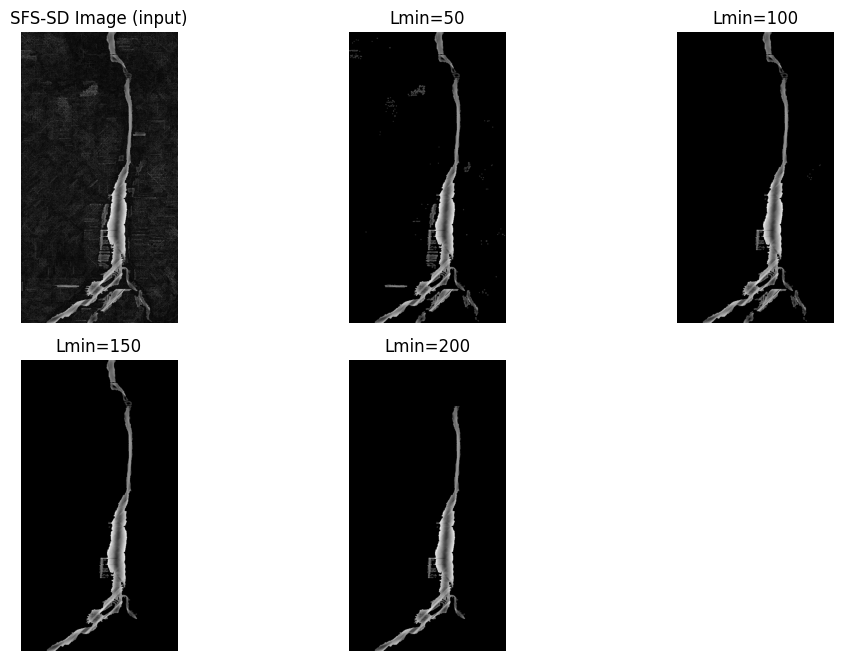

In [ ]:
# Implementation using  ^
# - Loads the provided SFS_SD_vis image (assumed to already be SFS-SD / homogeneity result)
# - Builds a stack of path-opened images using Lmin = [50,100,150,200]
# - Computes prototypes L_min and L_max (pixel vectors with global min/max sum across stack)
# - Estimates per-pixel mass functions using an EKNN-like prototype-distance -> mass conversion

import numpy as np, cv2, os
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_opening
from collections import deque


uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

h,w = SFS_SD_vis.shape
print("Loaded SFS-SD image shape:", SFS_SD_vis.shape)

# BFS diameter helper (two-pass)
def component_diameter(coords_set):
    if not coords_set:
        return 0
    start = next(iter(coords_set))
    def bfs(start):
        q = deque([start])
        visited = {start: 0}
        while q:
            r, c = q.popleft()
            d = visited[(r,c)]
            for dr in (-1,0,1):
                for dc in (-1,0,1):
                    if dr == 0 and dc == 0:
                        continue
                    nr, nc = r+dr, c+dc
                    if (nr,nc) in coords_set and (nr,nc) not in visited:
                        visited[(nr,nc)] = d+1
                        q.append((nr,nc))
        far_node = max(visited.items(), key=lambda x: x[1])[0]
        far_dist = visited[far_node]
        return far_node, far_dist
    A, _ = bfs(start)
    _, diameter = bfs(A)
    return diameter

# path-opening mask function (keeps radiometry values when mask passes)
def path_opening_mask(sfs_img, percentile=78, Lmin=100):
    th_val = np.percentile(sfs_img, percentile)
    binary_candidate = (sfs_img >= th_val).astype(np.uint8)
    structure = np.ones((3,3), dtype=int)
    labeled, num_labels = label(binary_candidate, structure=structure)
    final_mask = np.zeros_like(binary_candidate, dtype=np.uint8)
    for lab in range(1, num_labels+1):
        comp_coords = np.argwhere(labeled == lab)
        coords_set = set((int(r),int(c)) for r,c in comp_coords)
        if len(coords_set) < Lmin:
            continue
        dia = component_diameter(coords_set)
        if dia >= Lmin:
            for (r,c) in coords_set:
                final_mask[r,c] = 1
    final_mask_clean = binary_opening(final_mask, structure=np.ones((3,3))).astype(np.uint8)
    return final_mask_clean

# PARAMETERS
Lmin_values = [50, 100, 150, 200]
percentile = 78
gamma = 0.6  # ignorance scaling

# Build stack: each element is radiometry (original SFS_SD_vis) masked by path-opening mask
stack = []
masks = []
for L in Lmin_values:
    mask = path_opening_mask(SFS_SD_vis, percentile=percentile, Lmin=L)
    masks.append(mask)
    img_masked = (SFS_SD_vis * mask).astype(np.uint8)
    stack.append(img_masked)

stack_arr = np.stack(stack, axis=-1).astype(np.float32)  # shape (h,w,N)
N = stack_arr.shape[-1]
sums = stack_arr.sum(axis=-1)  # sum across stack for each pixel

# prototypes: L_min (global min sum) and L_max (global max sum)
min_idx = np.unravel_index(np.argmin(sums), sums.shape)
max_idx = np.unravel_index(np.argmax(sums), sums.shape)
L_min_proto = stack_arr[min_idx]  # vector length N
L_max_proto = stack_arr[max_idx]
L_mid_proto = (L_min_proto + L_max_proto) / 2.0

print("Prototypes coords:", min_idx, max_idx)

# Flatten for per-pixel computation
flat_stack = stack_arr.reshape(-1, N)  # (h*w, N)
protos = np.vstack([L_min_proto, L_mid_proto, L_max_proto]).astype(np.float32)  # (3,N)

# ------distances and similarities---------
# Parameters
alpha = 1.0         # discounting coefficient (reliability)
gamma_val = 0.5     # positive real controlling exponential decay

# Euclidean distances between each pixel vector and each prototype
dists = np.linalg.norm(flat_stack[:, None, :] - protos[None, :, :], axis=-1)  # (M,3)

# Decreasing function φ_k(d_k) = exp( -γ_k * d_k² )   (Eq. 12)
phi = np.exp(-gamma_val * (dists ** 2))

# Compute partial mass functions m_k(x ∈ ω_i) and m_k(x ∈ Ω)  (Eq. 11)
# Each prototype is treated as an independent "information source"
mass_sources = []
for k in range(protos.shape[0]):
    mk = np.zeros((flat_stack.shape[0], 4))  # 3 classes + Ω (ignorance)
    mk[:, k] = alpha * phi[:, k]             # mass assigned to class ω_k
    mk[:, 3] = 1 - alpha * phi[:, k]         # remaining mass (ignorance Ω)
    mass_sources.append(mk)

# Dempster’s combination operator (Eq. 13–14)
def dempster_combine(m1, m2):
    """
    Combine two mass functions m1, m2 using Dempster's rule of combination.
    Each m: [N,4] = [C1, C2, C3, Ω]
    """
    combined = np.zeros_like(m1)

    # Conflict mass (denominator term in Eq.14)
    conflict = (
        m1[:,0]*(m2[:,1]+m2[:,2]) +
        m1[:,1]*(m2[:,0]+m2[:,2]) +
        m1[:,2]*(m2[:,0]+m2[:,1])
    )
    denom = 1 - conflict + 1e-8

    # Combine masses for each specific class
    for i in range(3):
        combined[:,i] = (
            m1[:,i]*(m2[:,i] + m2[:,3]) + m1[:,3]*m2[:,i]
        ) / denom

    # Combine mass assigned to Ω (ignorance)
    combined[:,3] = (m1[:,3] * m2[:,3]) / denom
    return combined

# 5️⃣ Sequentially combine all prototype sources
m_total = mass_sources[0]
for k in range(1, len(mass_sources)):
    m_total = dempster_combine(m_total, mass_sources[k])

mass_arr = m_total  # [M,4]

mass_maps = mass_arr.reshape(h, w, 4)
mC1 = mass_maps[:,:,0]; mC2 = mass_maps[:,:,1]; mC3 = mass_maps[:,:,2]; mO = mass_maps[:,:,3]


# ============================================================
# Done — 'mass_maps' now holds the combined belief masses
# ============================================================


# Hard segmentation (choose singleton with highest mass; mark unknown where m(Ω) dominates)
singletons = np.stack([mC1, mC2, mC3], axis=-1)
labels = np.argmax(singletons, axis=-1) + 1
unknown_mask = (mO > singletons.max(axis=-1))
labels[unknown_mask] = 0

# Display outputs preserving grayscale mapping (bright stays bright)
plt.figure(figsize=(10,10))
plt.subplot(3,3,1); plt.imshow(SFS_SD_vis, cmap='gray'); plt.title("SFS-SD Image (input)"); plt.axis('off')
for i,L in enumerate(Lmin_values):
    plt.subplot(3,3,2+i); plt.imshow(stack[i], cmap='gray'); plt.title(f"Lmin={L}"); plt.axis('off')
plt.tight_layout()
plt.show()

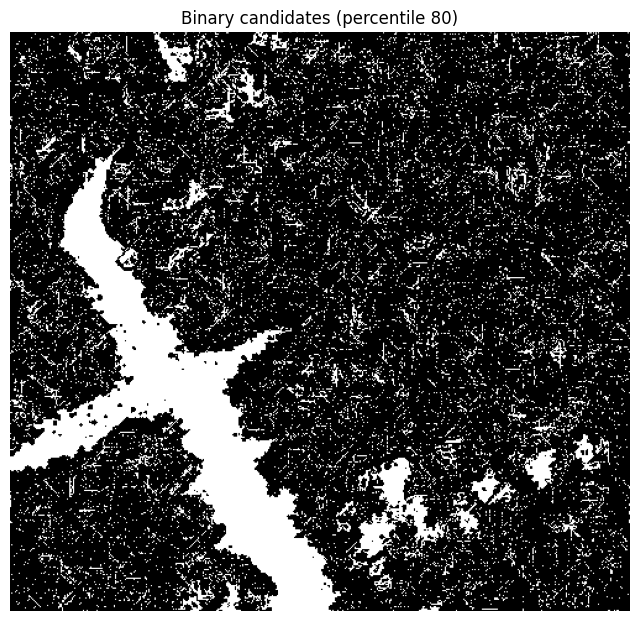

Connected components found: 7415


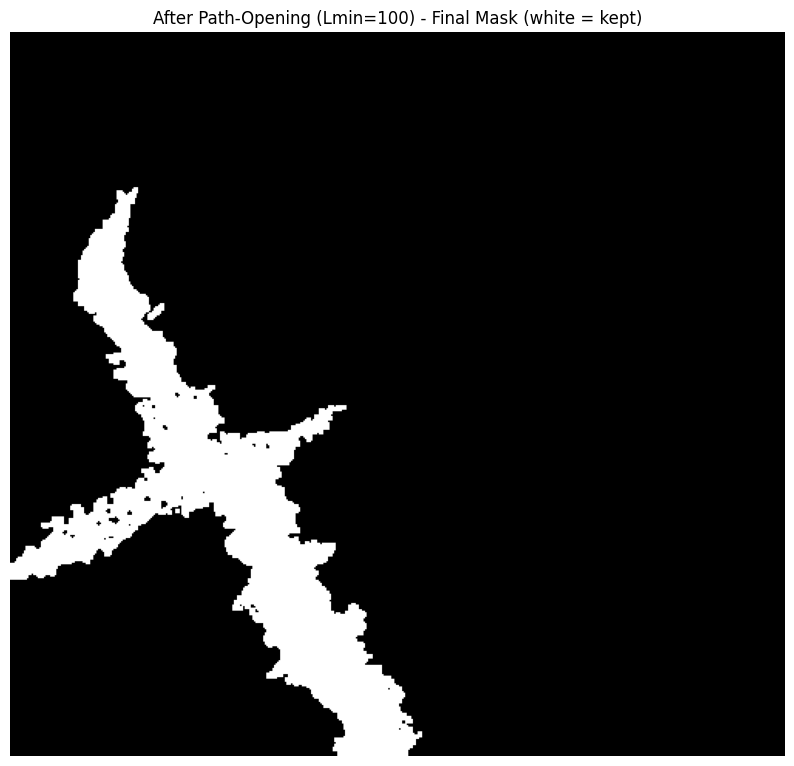

Saved: sfs_sd_vis.png binary_candidates.png final_pathopened_L100.png


In [ ]:
# ----------------- NEW SECTION: NON-TARGET OBJECT REMOVAL (PATH-OPENING) -----------------
from scipy.ndimage import label, binary_opening
from collections import deque

Lmin = 100  # keep only large water bodies

# 1) Threshold SFS_SD_vis to create binary candidate map
percentile = 80 # top X% brightest (most homogeneous)
th_val = np.percentile(SFS_SD_vis, percentile)
binary_candidate = (SFS_SD_vis >= th_val).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.title(f"Binary candidates (percentile {percentile})")
plt.imshow(binary_candidate, cmap='gray')
plt.axis('off')
plt.show()

# 2) Label connected components (8-connectivity)
structure = np.ones((3,3), dtype=int)
labeled, num_labels = label(binary_candidate, structure=structure)
print("Connected components found:", num_labels)

# Helper: BFS to compute diameter of a component
def component_diameter(coords_set):
    if not coords_set:
        return 0
    start = next(iter(coords_set))
    def bfs(start):
        q = deque([start])
        visited = {start: 0}
        while q:
            r, c = q.popleft()
            d = visited[(r,c)]
            for dr in (-1,0,1):
                for dc in (-1,0,1):
                    if dr == 0 and dc == 0:
                        continue
                    nr, nc = r+dr, c+dc
                    if (nr,nc) in coords_set and (nr,nc) not in visited:
                        visited[(nr,nc)] = d+1
                        q.append((nr,nc))
        far_node = max(visited.items(), key=lambda x: x[1])[0]
        far_dist = visited[far_node]
        return far_node, far_dist
    A, _ = bfs(start)
    _, diameter = bfs(A)
    return diameter

# 3) Keep only large components
final_mask = np.zeros_like(binary_candidate, dtype=np.uint8)
for lab in range(1, num_labels+1):
    comp_coords = np.argwhere(labeled == lab)
    coords_set = set((int(r),int(c)) for r,c in comp_coords)
    if len(coords_set) < Lmin:
        continue
    dia = component_diameter(coords_set)
    if dia >= Lmin:
        for (r,c) in coords_set:
            final_mask[r,c] = 1

final_mask_clean = binary_opening(final_mask, structure=np.ones((3,3))).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.title(f"After Path-Opening (Lmin={Lmin}) - Final Mask (white = kept)")
plt.imshow(final_mask_clean, cmap='gray')
plt.axis('off')
plt.show()

# 5) Save results
cv2.imwrite("sfs_sd_vis.png", SFS_SD_vis)
cv2.imwrite("binary_candidates.png", (binary_candidate*255).astype(np.uint8))
cv2.imwrite(f"final_pathopened_L{Lmin}.png", (final_mask_clean*255).astype(np.uint8))
print("Saved:", "sfs_sd_vis.png", "binary_candidates.png", f"final_pathopened_L{Lmin}.png")


Saving Screenshot 2025-09-11 101944.png to Screenshot 2025-09-11 101944 (1).png


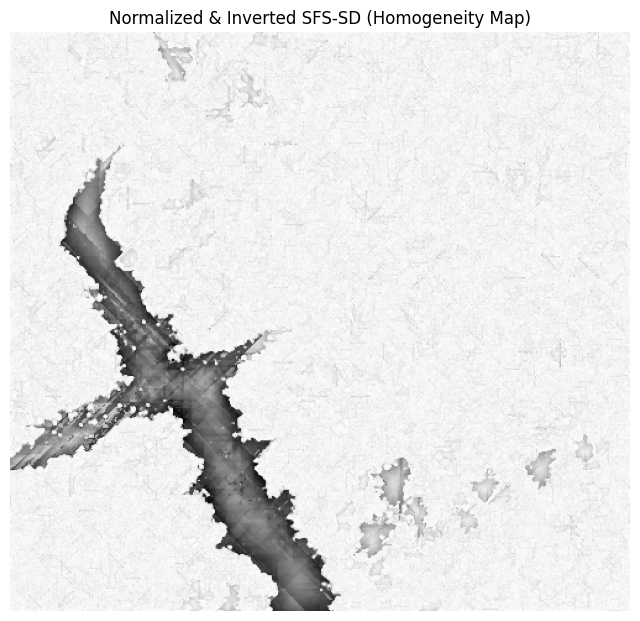

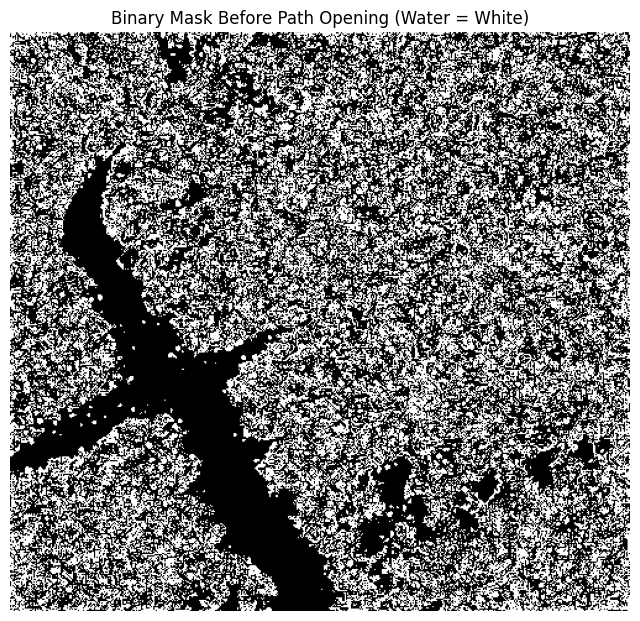

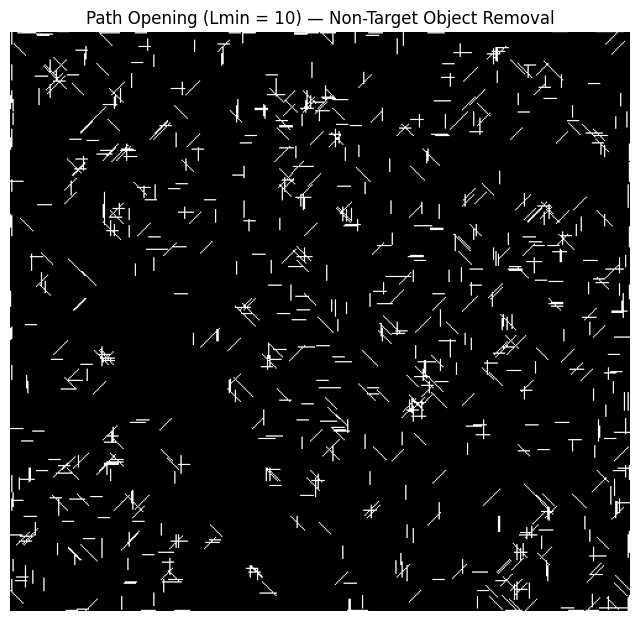

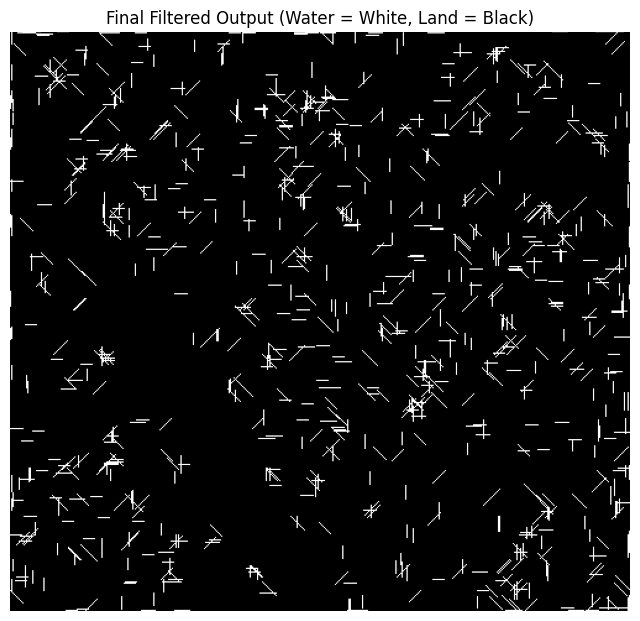

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import binary_opening

# ----------------- STEP 1: UPLOAD & LOAD IMAGE -----------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

# ----------------- STEP 2: DEFINE DIRECTIONS -----------------
# 8 directions: N, NE, E, SE, S, SW, W, NW
directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]
T1 = 20  # max intensity difference allowed
T2 = 40  # max pixel distance

# ----------------- STEP 3: COMPUTE SFS-SD -----------------
SFS_SD = np.zeros_like(img, dtype=np.float32)
PSI = np.zeros_like(img, dtype=np.float32)

for i in range(h):
    for j in range(w):
        di_list = []
        for dy, dx in directions:
            y, x = i, j
            length = 0
            while True:
                y_new, x_new = y + dy, x + dx
                if y_new < 0 or y_new >= h or x_new < 0 or x_new >= w:
                    break
                PH = abs(img[y_new, x_new] - img[i, j])  # Eq. (1): PH
                if PH > T1 or length >= T2:
                    break
                y, x = y_new, x_new
                length += 1
            di = np.sqrt((y - i)**2 + (x - j)**2)       # Eq. (2): d_i
            di_list.append(di)
        if len(di_list) > 0:
            PSI[i, j] = np.mean(di_list)                # Eq. (5): Ψ
            SFS_SD[i, j] = np.sqrt(np.sum((np.array(di_list) - PSI[i, j])**2) /
                                   (len(di_list) - 1 + 1e-6))  # Eq. (4): SD

# ----------------- STEP 4: NORMALIZATION -----------------
# Low SD = homogeneous (water), High SD = heterogeneous (land)
SFS_SD_norm = (SFS_SD - np.min(SFS_SD)) / (np.max(SFS_SD) - np.min(SFS_SD))
SFS_SD_norm = 1 - SFS_SD_norm  # invert so water = white, land = black

plt.figure(figsize=(8,8))
plt.title("Normalized & Inverted SFS-SD (Homogeneity Map)")
plt.imshow(SFS_SD_norm, cmap='gray')
plt.axis('off')
plt.show()

# ----------------- STEP 5: INITIAL THRESHOLDING -----------------
# Binary segmentation (water = white)
thr = np.percentile(SFS_SD_norm, 60)
binary_mask = (SFS_SD_norm >= thr).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.title("Binary Mask Before Path Opening (Water = White)")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

# ----------------- STEP 6: NON-TARGET OBJECT REMOVAL (Path Opening) -----------------
"""
Implements Equations (6)–(9) from the paper.

σ({x}) = {y ∈ I | x → y} defines adjacency-based dilation.
Path-opening α_L(X) = ∪{ o(a) | a ∈ L(X) } where a is an L-path satisfying adjacency.
We approximate this using directional morphological openings with structuring elements shaped as paths.
"""

# Set Lmin according to case
# Use high value (100) for pre-flood images to keep only large water bodies
# Use low value (10) for flood images to keep both large and small flooded areas
# You can switch manually depending on image type
Lmin = 10  # or 100 depending on dataset

angles = [0, 45, 90, 135]
opened_union = np.zeros_like(binary_mask)

for angle in angles:
    if angle == 0:
        se = np.ones((1, Lmin))
    elif angle == 90:
        se = np.ones((Lmin, 1))
    elif angle == 45:
        se = np.eye(Lmin)
    elif angle == 135:
        se = np.fliplr(np.eye(Lmin))
    opened = binary_opening(binary_mask, structure=se)
    opened_union = np.maximum(opened_union, opened)

# ----------------- STEP 7: FINAL VISUALIZATION -----------------
plt.figure(figsize=(8,8))
plt.title(f"Path Opening (Lmin = {Lmin}) — Non-Target Object Removal")
plt.imshow(opened_union, cmap='gray')
plt.axis('off')
plt.show()

final_vis = opened_union * 255
plt.figure(figsize=(8,8))
plt.title("Final Filtered Output (Water = White, Land = Black)")
plt.imshow(final_vis, cmap='gray')
plt.axis('off')
plt.show()


Streaming output truncated to the last 5000 lines.
[np.float64(0.0)]
[np.float64(0.0), np.float64(0.0)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(1.4142135623730951)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(1.4142135623730951), np.float64(1.0)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(1.4142135623730951), np.float64(1.0), np.float64(0.0)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(1.4142135623730951), np.float64(1.0), np.float64(0.0), np.float64(3.0)]
[np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(1.4142135623730951), np.float64(1.0), np.float64(0.0), np.float64(3.0), np.float64(1.4142135623730951)]
[np.float64(0.0)]
[np.float64(0.0), np.float64(2.8284271247461903)]
[np.float64(0.0), np.float64(2.8284271247461903), np.float64(2.0)]
[np.float64(0.0), np.float64(2.8284271247461903), np.float64(2.0), np.float64(0.0)]
[np.float64(0.0), np

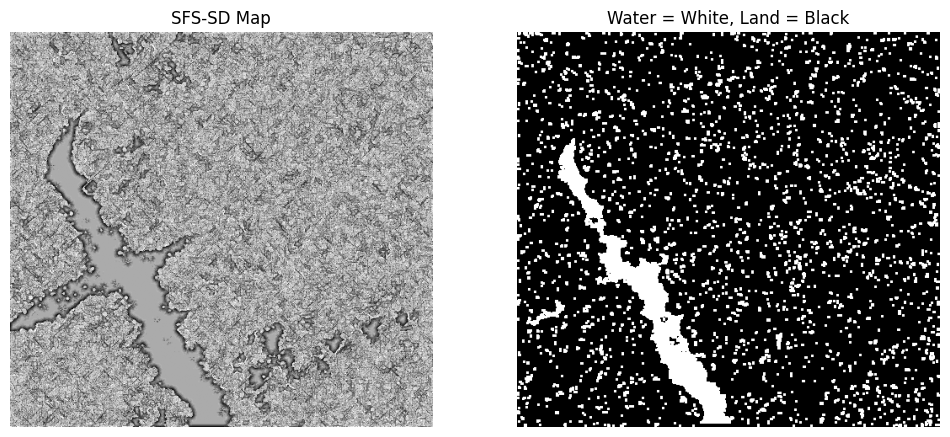

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import binary_opening

# ----------------- STEP 1: UPLOAD & LOAD IMAGE -----------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

# ----------------- STEP 2: DEFINE PARAMETERS & DIRECTIONS -----------------
directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]  # 8 directions
T1 = 20   # max radiometric difference along a direction
T2 = 5    # max pixels along a direction line

# ----------------- STEP 3: COMPUTE SFS-SD & PSI -----------------
SFS_SD = np.zeros_like(img, dtype=np.float32)
PSI = np.zeros_like(img, dtype=np.float32)

for i in range(h):
    for j in range(w):
        di_list = []
        for dy, dx in directions:
            y, x = i, j
            length = 0
            while True:
                y_new, x_new = y + dy, x + dx
                # stop if outside image
                if y_new < 0 or y_new >= h or x_new < 0 or x_new >= w:
                    break
                PH = abs(img[y_new, x_new] - img[i, j])
                if PH > T1 or length >= T2:
                    break
                y, x = y_new, x_new
                length += 1
            # distance from central pixel to last pixel in this direction
            di = np.sqrt((y - i)**2 + (x - j)**2) #EQUATION 2
            di_list.append(di)
            print(di_list)
        if len(di_list) > 0:
            PSI[i,j] = np.mean(di_list) #PSI MEAN DISTANCE
            # standard deviation, add small eps to avoid div by zero
            SFS_SD[i,j] = np.sqrt(np.sum((np.array(di_list) - PSI[i,j])**2) / (len(di_list)-1 + 1e-6))

# ----------------- STEP 4: INVERT SFS-SD FOR WATER WHITE -----------------
# Low SD = homogeneous (water) → map to white
SFS_SD_inv = np.max(SFS_SD) - SFS_SD
SFS_SD_norm = (SFS_SD_inv - np.min(SFS_SD_inv)) / (np.max(SFS_SD_inv) - np.min(SFS_SD_inv)) * 255
SFS_SD_norm = SFS_SD_norm.astype(np.uint8)

# ----------------- STEP 5: THRESHOLD & CLEAN -----------------
# Threshold to separate water from land
threshold = np.percentile(SFS_SD_norm, 50)  # adaptively choose mid value
binary_water = np.zeros_like(SFS_SD_norm, dtype=np.uint8)
binary_water[SFS_SD_norm >= threshold] = 255  # water white
binary_water[SFS_SD_norm < threshold] = 0     # land black

# Morphological opening to remove small speckles
binary_water_clean = binary_opening(binary_water, structure=np.ones((3,3))).astype(np.uint8)

# ----------------- STEP 6: DISPLAY RESULTS -----------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("SFS-SD Map")
plt.imshow(SFS_SD_norm, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Water = White, Land = Black")
plt.imshow(binary_water_clean, cmap='gray')
plt.axis('off')

plt.show()


Saving Screenshot 2025-09-11 101944.png to Screenshot 2025-09-11 101944 (2).png


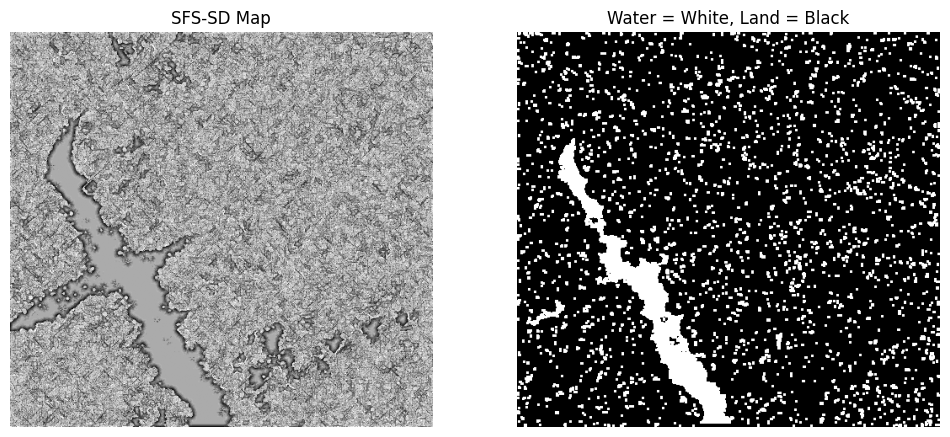

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import binary_opening

# ----------------- STEP 1: UPLOAD & LOAD IMAGE -----------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = img.shape

# ----------------- STEP 2: DEFINE PARAMETERS & DIRECTIONS -----------------
directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]  # 8 directions
T1 = 20   # max radiometric difference along a direction
T2 = 5    # max pixels along a direction line

# ----------------- STEP 3: COMPUTE SFS-SD & PSI -----------------
SFS_SD = np.zeros_like(img, dtype=np.float32)
PSI = np.zeros_like(img, dtype=np.float32)

for i in range(h):
    for j in range(w):
        di_list = []
        for dy, dx in directions:
            y, x = i, j
            length = 0
            while True:
                y_new, x_new = y + dy, x + dx
                # stop if outside image
                if y_new < 0 or y_new >= h or x_new < 0 or x_new >= w:
                    break
                PH = abs(img[y_new, x_new] - img[i, j])
                if PH > T1 or length >= T2:
                    break
                y, x = y_new, x_new
                length += 1
            # distance from central pixel to last pixel in this direction
            di = np.sqrt((y - i)**2 + (x - j)**2)
            di_list.append(di)
        if len(di_list) > 0:
            PSI[i,j] = np.mean(di_list)
            # standard deviation, add small eps to avoid div by zero
            SFS_SD[i,j] = np.sqrt(np.sum((np.array(di_list) - PSI[i,j])**2) / (len(di_list)-1 + 1e-6))

# ----------------- STEP 4: INVERT SFS-SD FOR WATER WHITE -----------------
# Low SD = homogeneous (water) → map to white
SFS_SD_inv = np.max(SFS_SD) - SFS_SD
SFS_SD_norm = (SFS_SD_inv - np.min(SFS_SD_inv)) / (np.max(SFS_SD_inv) - np.min(SFS_SD_inv)) * 255
SFS_SD_norm = SFS_SD_norm.astype(np.uint8)

# ----------------- STEP 5: THRESHOLD & CLEAN -----------------
# Threshold to separate water from land
threshold = np.percentile(SFS_SD_norm, 50)  # adaptively choose mid value
binary_water = np.zeros_like(SFS_SD_norm, dtype=np.uint8)
binary_water[SFS_SD_norm >= threshold] = 255  # water white
binary_water[SFS_SD_norm < threshold] = 0     # land black

# Morphological opening to remove small speckles
binary_water_clean = binary_opening(binary_water, structure=np.ones((3,3))).astype(np.uint8)

# ----------------- STEP 6: DISPLAY RESULTS -----------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("SFS-SD Map")
plt.imshow(SFS_SD_norm, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Water = White, Land = Black")
plt.imshow(binary_water_clean, cmap='gray')
plt.axis('off')

plt.show()
